In [61]:
import random
from math import exp
import matplotlib.pyplot as plt
# process data label as 0, 1, 2 for training
def loadDataset(dataset): 
    newdata = []
    for x in range(len(dataset)-1):
        for i in range(0,len(dataset[x]),4):
            if dataset[x][i] == "I": # encounter labels, change it
                if dataset[x][-3:-1] == "sa": # Iris-setosa
                    newdata.append(0)
                elif dataset[x][-2:-1] == "r": # Iris-versicolor
                    newdata.append(1)
                elif dataset[x][-3:-1] == "ca": # Iris-virginica
                    newdata.append(2) 
                break
            else:
                attribute = float(dataset[x][i:i+3])
                newdata.append(attribute)
        trainingSet.append(newdata)       
        newdata = [] # clear the package
    return trainingSet

# find the range of data to do normalize
def dataset_minmax(dataset): # zip a(1,2,3) , b(4,5,6) to [(1,4), (2,5), (3,6)] 
    minmax = list()
    stats = [[min(column), max(column)] for column in zip(*dataset)] # unzip the file
    return stats

# rescale data to range 0~1
def normalize_data(dataset, minmax):
    for row in dataset:
        for i in range(len(row)-1):
            row[i] = (row[i] - minmax[i][0]) / (minmax[i][1] - minmax[i][0])

# calculate neuron activation for an input
def activate(weights, inputs):
    activation = weights[-1]
    for i in range(len(weights)-1):
        activation += weights[i] * inputs[i]
    return activation

# transfer neuron activation 
def transfer(activation):
    return 1.0 / (1.0 + exp(-activation))

# calculate the derivative of an neuron output
def transfer_derivative(output):
    return output * (1.0 - output)

#forward propagate input to a network output
def forward_propagate(network, row):
    inputs = row
    for layer in network:
        new_inputs = []
        for neuron in layer:
            activation = activate(neuron['weights'], inputs)
            neuron['output'] = transfer(activation)
            new_inputs.append(neuron['output'])
        inputs = new_inputs # keep updating the neurons
    return inputs

# backpropagate error and sotre in neurons
def backward_propagate_error(network, expected): 
    for i in reversed(range(len(network))):
        layer = network[i]
        errors = list()
        if i != len(network)-1:
            for j in range(len(layer)): # hidden
                error = 0.0
                for neuron in network[i+1]:
                    error += (neuron['weights'][j] * neuron['delta'])
                errors.append(error) 
        else:
            for j in range(len(layer)): # output
                neuron = layer[j]
                errors.append(expected[j] - neuron['output'])
        for j in range(len(layer)):
            neuron = layer[j]
            neuron['delta'] = errors[j] * transfer_derivative(neuron['output'])

# update network weights with error
def update_weights(network, row, learning_rate):
    for i in range(len(network)):
        inputs = row[:-1]
        if i != 0:
            inputs = [neuron['output'] for neuron in network[i-1]]
        for neuron in network[i]:
            for j in range(len(inputs)):
                neuron['weights'][j] += learning_rate * neuron['delta'] * inputs[j]
            neuron['weights'][-1] += learning_rate * neuron['delta']

def train_network(network, train, learning_rate, n_epoch, n_outputs):
    print("--------------- lrate=%.3f" % learning_rate ,"-----------------")
    prev_MSE = 0
    MSE = 0
    abs_fraction_of_change = 0
    for epoch in range(n_epoch):
        MSE = 0
        for row in train:
            outputs = forward_propagate(network, row)
            expected = [0 for i in range(n_outputs)]
            expected[row[-1]] = 1 # one hot encoding !!!
            backward_propagate_error(network, expected)
            update_weights(network, row, learning_rate)
            update_outputs = forward_propagate(network, row) # update forward results
            MSE += sum([(expected[i] - update_outputs[i])**2 for i in range(len(expected))])
            #print(MSE)
        MSE /= len(expected)
        if epoch > 0:
            abs_fraction_of_change = abs((MSE - prev_MSE) / prev_MSE )
            if abs_fraction_of_change <= 10e-5:
                print("Epoch need:%d"%(epoch+1))
                break
        print('>epoch=%d, MSE=%.3f, abs fraction of change=%.6f' % (epoch, MSE, abs_fraction_of_change))
        prev_MSE = MSE
        #print("prev",prev_MSE)
    return (epoch+1)
    
    

def init_network(n_inputs, n_hidden, n_outputs): 
# create n_hidden neurons and each neuron in the hidden layer has n_inputs + 1 weights
    network = list()
    hidden_layer1 = [{'weights': [(random.random()-0.5)/5.0 for i in range(n_inputs)]} for i in range(n_hidden)]
    network.append(hidden_layer1) 
    hidden_layer2 = [{'weights': [(random.random()-0.5)/5.0 for i in range(n_inputs)]} for i in range(n_hidden)]
    network.append(hidden_layer2)
    output_layer = [{'weights': [(random.random()-0.5)/5.0 for i in range(n_hidden)]} for i in range(n_outputs)]
    network.append(output_layer) 
    #for i in network:
     #   print(i)
    return network

# make a prediction with a network
# It returns the index in the network output that has the largest probability. 
# Assuming that class values have been converted to integers starting at 0. [0,1,2]
def predict(network, row):
    outputs = forward_propagate(network, row)
    return outputs.index(max(outputs))

# backpropagation with stochastic gradient descent
def back_propagate(train, learning_rate, n_epoch, n_hidden):
    n_inputs = len(train[0]) - 1
    n_outputs = len(set([row[-1] for row in train]))
    network = init_network(n_inputs, n_hidden, n_outputs)
    epoch = train_network(network, train, learning_rate, n_epoch, n_outputs)
    return epoch
    

In [62]:
trainingSet=[]
testSet=[]
results = []
f = open('iris.data.txt', "r")
lines = f.readlines()
dataset = list(lines)
trainingSet = loadDataset(dataset)

In [63]:
# normalize inputs

minmax = dataset_minmax(trainingSet)
normalize_data(trainingSet, minmax)

learning_rate = 0.1
n_epoch = 300
n_hidden = 4

epoch = back_propagate(trainingSet, learning_rate, n_epoch, n_hidden)
results.append(epoch)

--------------- lrate=0.100 -----------------
>epoch=0, MSE=29.742, abs fraction of change=0.000000
>epoch=1, MSE=30.866, abs fraction of change=0.037813
>epoch=2, MSE=31.293, abs fraction of change=0.013828
>epoch=3, MSE=31.389, abs fraction of change=0.003045
>epoch=4, MSE=31.418, abs fraction of change=0.000924
>epoch=5, MSE=31.433, abs fraction of change=0.000500
>epoch=6, MSE=31.446, abs fraction of change=0.000414
>epoch=7, MSE=31.459, abs fraction of change=0.000395
>epoch=8, MSE=31.471, abs fraction of change=0.000389
>epoch=9, MSE=31.483, abs fraction of change=0.000386
>epoch=10, MSE=31.495, abs fraction of change=0.000384
>epoch=11, MSE=31.507, abs fraction of change=0.000382
>epoch=12, MSE=31.519, abs fraction of change=0.000380
>epoch=13, MSE=31.531, abs fraction of change=0.000377
>epoch=14, MSE=31.543, abs fraction of change=0.000375
>epoch=15, MSE=31.555, abs fraction of change=0.000373
>epoch=16, MSE=31.566, abs fraction of change=0.000370
>epoch=17, MSE=31.578, abs fr

In [69]:
# normalize inputs
dataset = list(lines)
trainingSet = loadDataset(dataset) #reload data
minmax = dataset_minmax(trainingSet)
normalize_data(trainingSet, minmax)

learning_rate = 0.2
n_epoch = 300
n_hidden = 4

epoch = back_propagate(trainingSet, learning_rate, n_epoch, n_hidden)
results.append(epoch)

--------------- lrate=0.200 -----------------
>epoch=0, MSE=164.342, abs fraction of change=0.000000
>epoch=1, MSE=171.805, abs fraction of change=0.045414
>epoch=2, MSE=174.669, abs fraction of change=0.016668
>epoch=3, MSE=177.168, abs fraction of change=0.014310
>epoch=4, MSE=179.254, abs fraction of change=0.011770
>epoch=5, MSE=180.957, abs fraction of change=0.009500
>epoch=6, MSE=182.341, abs fraction of change=0.007651
>epoch=7, MSE=183.471, abs fraction of change=0.006196
>epoch=8, MSE=184.398, abs fraction of change=0.005053
>epoch=9, MSE=185.163, abs fraction of change=0.004150
>epoch=10, MSE=185.800, abs fraction of change=0.003440
>epoch=11, MSE=186.335, abs fraction of change=0.002881
>epoch=12, MSE=186.789, abs fraction of change=0.002432
>epoch=13, MSE=187.175, abs fraction of change=0.002066
>epoch=14, MSE=187.505, abs fraction of change=0.001767
>epoch=15, MSE=187.791, abs fraction of change=0.001522
>epoch=16, MSE=188.039, abs fraction of change=0.001321
>epoch=17, M

In [65]:
# normalize inputs
trainingSet = loadDataset(dataset) #reload data
minmax = dataset_minmax(trainingSet)
normalize_data(trainingSet, minmax)

learning_rate = 0.3
n_epoch = 300
n_hidden = 4

epoch = back_propagate(trainingSet, learning_rate, n_epoch, n_hidden)
results.append(epoch)

--------------- lrate=0.300 -----------------
>epoch=0, MSE=71.576, abs fraction of change=0.000000
>epoch=1, MSE=77.889, abs fraction of change=0.088201
>epoch=2, MSE=79.594, abs fraction of change=0.021902
>epoch=3, MSE=81.188, abs fraction of change=0.020020
>epoch=4, MSE=82.593, abs fraction of change=0.017311
>epoch=5, MSE=83.792, abs fraction of change=0.014517
>epoch=6, MSE=84.799, abs fraction of change=0.012018
>epoch=7, MSE=85.641, abs fraction of change=0.009930
>epoch=8, MSE=86.347, abs fraction of change=0.008235
>epoch=9, MSE=86.938, abs fraction of change=0.006847
>epoch=10, MSE=87.434, abs fraction of change=0.005700
>epoch=11, MSE=87.850, abs fraction of change=0.004765
>epoch=12, MSE=88.203, abs fraction of change=0.004018
>epoch=13, MSE=88.505, abs fraction of change=0.003425
>epoch=14, MSE=88.766, abs fraction of change=0.002950
>epoch=15, MSE=88.994, abs fraction of change=0.002564
>epoch=16, MSE=89.194, abs fraction of change=0.002248
>epoch=17, MSE=89.371, abs fr

In [66]:
# normalize inputs
trainingSet = loadDataset(dataset) #reload data
minmax = dataset_minmax(trainingSet)
normalize_data(trainingSet, minmax)

learning_rate = 0.4
n_epoch = 300
n_hidden = 4

epoch = back_propagate(trainingSet, learning_rate, n_epoch, n_hidden)
results.append(epoch)

--------------- lrate=0.400 -----------------
>epoch=0, MSE=87.168, abs fraction of change=0.000000
>epoch=1, MSE=96.451, abs fraction of change=0.106491
>epoch=2, MSE=100.811, abs fraction of change=0.045208
>epoch=3, MSE=104.355, abs fraction of change=0.035151
>epoch=4, MSE=106.995, abs fraction of change=0.025297
>epoch=5, MSE=108.934, abs fraction of change=0.018122
>epoch=6, MSE=110.362, abs fraction of change=0.013116
>epoch=7, MSE=111.415, abs fraction of change=0.009537
>epoch=8, MSE=112.202, abs fraction of change=0.007066
>epoch=9, MSE=112.806, abs fraction of change=0.005381
>epoch=10, MSE=113.280, abs fraction of change=0.004201
>epoch=11, MSE=113.661, abs fraction of change=0.003367
>epoch=12, MSE=113.975, abs fraction of change=0.002760
>epoch=13, MSE=114.236, abs fraction of change=0.002286
>epoch=14, MSE=114.453, abs fraction of change=0.001901
>epoch=15, MSE=114.634, abs fraction of change=0.001587
>epoch=16, MSE=114.788, abs fraction of change=0.001337
>epoch=17, MSE

In [67]:
# normalize inputs
trainingSet = loadDataset(dataset) #reload data
minmax = dataset_minmax(trainingSet)
normalize_data(trainingSet, minmax)

learning_rate = 0.5
n_epoch = 300
n_hidden = 4

epoch = back_propagate(trainingSet, learning_rate, n_epoch, n_hidden)
results.append(epoch)

--------------- lrate=0.500 -----------------
>epoch=0, MSE=102.874, abs fraction of change=0.000000
>epoch=1, MSE=116.641, abs fraction of change=0.133823
>epoch=2, MSE=123.851, abs fraction of change=0.061810
>epoch=3, MSE=128.472, abs fraction of change=0.037308
>epoch=4, MSE=131.345, abs fraction of change=0.022369
>epoch=5, MSE=133.172, abs fraction of change=0.013904
>epoch=6, MSE=134.358, abs fraction of change=0.008909
>epoch=7, MSE=135.175, abs fraction of change=0.006084
>epoch=8, MSE=135.769, abs fraction of change=0.004389
>epoch=9, MSE=136.219, abs fraction of change=0.003318
>epoch=10, MSE=136.570, abs fraction of change=0.002573
>epoch=11, MSE=136.845, abs fraction of change=0.002013
>epoch=12, MSE=137.063, abs fraction of change=0.001595
>epoch=13, MSE=137.239, abs fraction of change=0.001286
>epoch=14, MSE=137.384, abs fraction of change=0.001058
>epoch=15, MSE=137.506, abs fraction of change=0.000887
>epoch=16, MSE=137.610, abs fraction of change=0.000757
>epoch=17, M

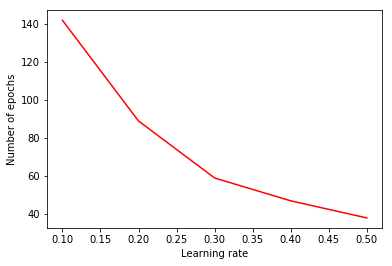

In [68]:
plt.plot([0.1, 0.2, 0.3, 0.4, 0.5], results, 'r')
plt.xlabel("Learning rate")
plt.ylabel("Number of epochs")
plt.show()